# CosmoX Python interface demo

In [1]:
import cosmox
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

## Perturbations

Let's run the CLASS code to create a CosmoX `Perturbations` instance.

The configuration file `cosmoclass.ini` is a standard one for
CLASS. The file is passed directly to CLASS, no additional checks are
performed. Hence if we need, e.g., velocity perturbations, an option
should be included to make sure that CLASS will compute them (e.g.,
ask for redshift-space distortion `rsd` number counts, even though we
do not actually compute spectra with CLASS).

In [2]:
pt = cosmox.Perturbations_create_perturbs (cosmox.kCosmoclass,
                                           "cosmoclass.ini")

CLASS has now computed perturbations or, more precisely, "source
functions" (i.e., perturbations normalized to some value of initial
curvature perturbations).

Print some background quantity. Lenghts are always in Mpc.

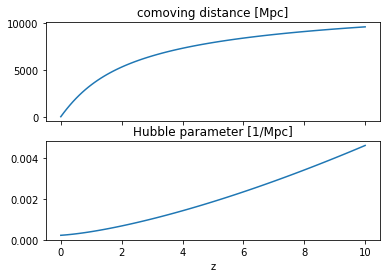

In [3]:
zgrid = np.linspace(0., 10., 100)
fig, (ax1, ax2) = plt.subplots(2, sharex=True)
ax1.plot(zgrid, [pt.bg_comoving_distance(z) for z in zgrid])
ax1.set_title("comoving distance [Mpc]")
ax2.plot(zgrid, [pt.bg_Hubble(z) for z in zgrid])
ax2.set_title("Hubble parameter [1/Mpc]")
ax2.set_xlabel("z");

Plot dimensionless primordial power spectrum of curvature
perturbations.

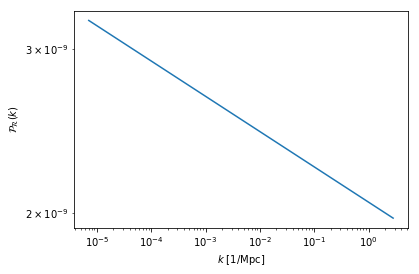

In [4]:
kmin, kmax = pt.get_k_lims() # 1/Mpc
kgrid = np.logspace(np.log10(kmin), np.log10(kmax), 1000)
Pkgrid = [pt.get_primordial_spectrum(k) for k in kgrid]

plt.loglog(kgrid, Pkgrid)
plt.xlabel("$k$ [1/Mpc]")
plt.ylabel("$\mathcal{P}_{\mathcal{R}}(k)$");

Plot the total matter density source function $S_{\delta_M}(k, z)$.

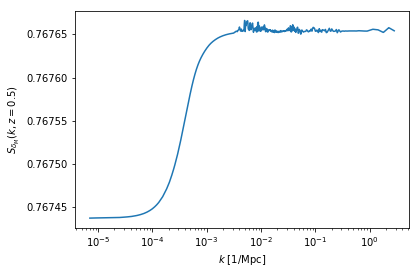

In [5]:
z = 0.5
sgrid = [pt.get_source(pt.kDeltaM, k, z)/pt.get_source(pt.kDeltaM, k, 0.)
         for k in kgrid]        # Normalize source function at z=0.

plt.semilogx(kgrid, sgrid)
plt.xlabel("$k$ [1/Mpc]")
plt.ylabel("$S_{\delta_M}(k, z=0.5)$");

## Generalized spectra

Create an instance of CosmoX `GeneralSpectra` using the perturbations
previously computed.

In [6]:
gsp = cosmox.GeneralSpectra(pt)

Generalized spectra are complex numbers in general (see equation A.8
of [arxiv:1510.04202](https://arxiv.org/pdf/1510.04202.pdf)). For
instance, consider the following one based on the density transfer
function.

In [7]:
n = 0
z1 = z2 = 0.5
l1 = 10
l2 = l1+1
gsp.compute(l1, l2, z1, z2, n, gsp.kDensity, gsp.kDensity)

-6.218477159874826e-05j

Create a wrapper function to retrieve standard spectra as real numbers.

(This example illustrates the generic `cosmox.GeneralSpectra` interface. 
`cosmox.Spectrum` is a simpler option for the particular but frequent case 
of the regular angular power spectrum. However, CosmoX does not aim at providing
optimized regular power spectra, other solutions like the CLASS csomological
code are a better option.)

In [8]:
def spectra(ell, z1, z2, ttype1, ttype2, epsrel=1e-4):
    """Compute standard spectra based on the given transfer types.
       The numerical integration estimated relative precision `epsrel`
       is an optional parameter.
    """
    n = 0
    l1 = l2 = int(ell) # Avoid incorrect type errors.
    return gsp.compute(l1, l2, z1, z2, n, ttype1, ttype2, epsrel).real

Define redshift-space spectra (density and rsd) spectra.

In [9]:
def redshift_space_spectra(ell, z1, z2):
    """Compute angular spectra in redshift space (density and rsd
       correlations).
    """
    # See the documentation for the C++ GeneralSpectra class:
    # - gsp.kDensity: density transfer function.
    # - gsp.kVelocity1: rsd transfer function.
    return (spectra(ell, z1, z2, gsp.kDensity, gsp.kDensity)
            + spectra(ell, z1, z2, gsp.kDensity, gsp.kVelocity1)
            + spectra(ell, z1, z2, gsp.kVelocity1, gsp.kDensity)
            + spectra(ell, z1, z2, gsp.kVelocity1, gsp.kVelocity1))

Plot the auto-correlations of the density and rsd spectra, and of the
total one.

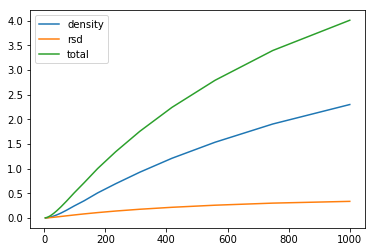

In [10]:
z1 = z2 = 0.5

lgrid = np.logspace(np.log10(4), np.log10(1000), 20)
Cl_density = [spectra(l, z1, z2, gsp.kDensity, gsp.kDensity)
              for l in lgrid]
Cl_rsd = [spectra(l, z1, z2, gsp.kVelocity1, gsp.kVelocity1)
              for l in lgrid]
Cl_total = [redshift_space_spectra(l, z1, z2)
            for l in lgrid]

fig, ax = plt.subplots()
ax.plot(lgrid, lgrid*(lgrid+1.0)/(2*np.pi)*Cl_density, label='density')
ax.plot(lgrid, lgrid*(lgrid+1.0)/(2*np.pi)*Cl_rsd, label='rsd')
ax.plot(lgrid, lgrid*(lgrid+1.0)/(2*np.pi)*Cl_total, label='total')
ax.legend();

## Bispectra

### Density dipole bispectrum

Compute the density dipole reduced bispectrum, equation A.20 of
[arxiv:1510.04202](https://arxiv.org/pdf/1510.04202.pdf).

In [11]:
def b_dens_dipole_oneperm(l1, l2, l3, z1, z2, z3, epsrel=1e-4):
    """Compute one permutation of the density dipole bispectrum.
       Return zero if the reducedGaunt factor is zero.
    """
    l1 = int(l1) # Avoid incorrect type errors.
    l2 = int(l2)
    l3 = int(l3)
    wig = cosmox.Wigner(2 * (max(max(l1, l2), l3) + 1))
    gaunt = cosmox.geometry_reduced_Gaunt(l1, l2, l3, wig)
    if (gaunt==0): # Total bispectrum not defined.
        return 0.0
    lp_grid = [l2-1, l2+1]
    lpp_grid = [l1-1, l1+1]
    ttype = gsp.kDensity
    res = sum(((2*lp+1) * (2*lpp+1) 
               * cosmox.geometry_Q(l1, l2, l3, 1, lp, lpp, wig)
               * (gsp.compute(lpp, l1, z3, z1, 1, ttype, ttype, epsrel)
                  * gsp.compute(lp, l2, z3, z2, -1, ttype, ttype, epsrel)
                  + gsp.compute(lpp, l1, z3, z1, -1, ttype, ttype, epsrel)
                  * gsp.compute(lp, l2, z3, z2, 1, ttype, ttype, epsrel)))
              for lp in lp_grid
              for lpp in lpp_grid)
    res /= (16.*np.pi**2 * gaunt)
    return res.real

def b_dens_dipole(l1, l2, l3, z1, z2, z3, epsrel=1e-4):
    """Compute all permutations of the density dipole bispectrum."""
    return (b_dens_dipole_oneperm(l1, l2, l3, z1, z2, z3, epsrel=epsrel)
           + b_dens_dipole_oneperm(l2, l3, l1, z2, z3, z1, epsrel=epsrel)
           + b_dens_dipole_oneperm(l3, l1, l2, z3, z1, z2, epsrel=epsrel))

Plot the bispectrum auto-correlation at $z=0.5$ for the
$\ell_1=\ell_2=\ell_3/2$ multipoles configuration.

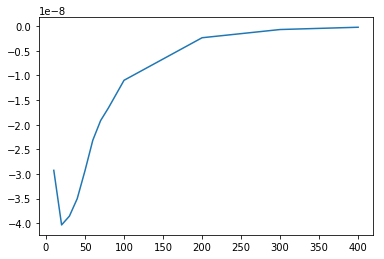

In [12]:
z1 = z2 = z3 = 0.5

lgrid = np.concatenate([np.arange(10, 90, 10),
                        np.arange(100, 500, 100)])
epsrel = 1e-4
blgrid = [b_dens_dipole(l, l, 2*l, z1, z2, z3, epsrel)
          for l in lgrid]

plt.plot(lgrid, blgrid);